# 서울 자전거 수요량 데이터

본 노트북은 '파이썬 머신러닝 완벽가이드(위키북스) - 권철민' 책을 바탕으로 배운 분석을 실습해보는데 의의를 두었습니다.

연습 데이터 : https://archive.ics.uci.edu/ml/datasets/Seoul+Bike+Sharing+Demand 


### 목차
[**Exploratory Data Analysis(EDA) & Feature Engineering and Data Cleaning**](#Exploratory-Data-Analysis(EDA)-&-Feature-Engineering-and-Data-Cleaning)


[**Predictive Modeling**](#Predictive-Modeling)

[단순선형회귀](#단순선형회귀)

[릿지회귀](#릿지회귀)

[라쏘회귀](#라쏘회귀)

[회귀트리](#회귀트리)


[**Dimension Reduction**](#Dimension-Reduction)

[PCA](#PCA)

[LDA](#LDA)

[SVD](#SVD)


[**스태킹**](#스태킹)

[기본 스태킹](#기본-스태킹)

[CV를 활용한 스태킹](#CV를-활용한-스태킹)


[**군집화**](#군집화)

[K-Mean](#K-Mean)



## Exploratory Data Analysis(EDA) & Feature Engineering and Data Cleaning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt #시각화 패키지
import seaborn as sns #시각화 패키지
plt.style.use('fivethirtyeight') # 테마바꾸기
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from tqdm import tnrange, tqdm_notebook, notebook
import time

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, scale

from sklearn.linear_model import RidgeCV, Ridge, LassoCV, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans

# 실루엣 분석 metric 값을 구하기 위한 API 추가
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.datasets import make_blobs, load_boston
import matplotlib.cm as cm

In [1]:
data=pd.read_csv('../SeoulBikeData.csv', engine='python', encoding='CP949')
data.head() # data 확인

,Date,Rented Bike Count,Hour,Temperature(ºC),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(ºC),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


Date : 일/월/년

Rented Bike count - 시간당 대여 횟수

Hour - 하루 시간

Temperature-섭씨기온

Humidity - 습도(%)

Windspeed - 풍속(m/s)

Visibility - 가시거리(10m)

Dew point temperature - 이슬점(Celsius)

Solar radiation - 자외선 지수(MJ/m2)

Rainfall - 강우량(mm)

Snowfall - 강설량(cm)

Seasons - 계절(Winter, Spring, Summer, Autumn)

Holiday - 주말/평일(Holiday/No holiday)

Functional Day - 비운행일, 운행일 (NoFunc(Non Functional Hours), Fun(Functional hours))

In [2]:
data.isnull().sum() # 전체 결측치 확인

Date                         0
Rented Bike Count            0
Hour                         0
Temperature(ºC)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(ºC)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64

In [3]:
data.describe()

,Rented Bike Count,Hour,Temperature(ºC),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(ºC),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


Functioning day 변수는 자전거 대여 정책이 실시되는 Yes와 실시하지 않는 No로 구분된다. 

Functioning day가 No인 날은 자전거 대여가 당연히 없고 이에 관련된 다른 변수들이 예측을 위한 분석과정에 포함될 경우 정확도를 낮출 수 있다.

Functioning day의 Yes와 No를 각각 0과 1로 변환 후 0인 데이터만 추출 (Functioning day 변수는 의미가 없어졌으므로 제거)

In [4]:
data['Functioning Day'].replace(['Yes','No'],[0,1],inplace=True)
data=data.loc[data['Functioning Day']==0]
data.head()

,Date,Rented Bike Count,Hour,Temperature(ºC),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(ºC),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,0
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,0
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,0
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,0
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,0


In [5]:
data.drop("Functioning Day",axis=1,inplace=True)

In [6]:
data.head()

,Date,Rented Bike Count,Hour,Temperature(ºC),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(ºC),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday


변수 중에서 설명이 필요할 것 같은 데이터는 time(시간), seasons(계절), visibility(가시성), holiday(휴일 여부), functioning day(정책 실행 여부), rainfall(강수량), Dew point temperature(이슬점), solar radiation(자외선 지수) 등 이다.

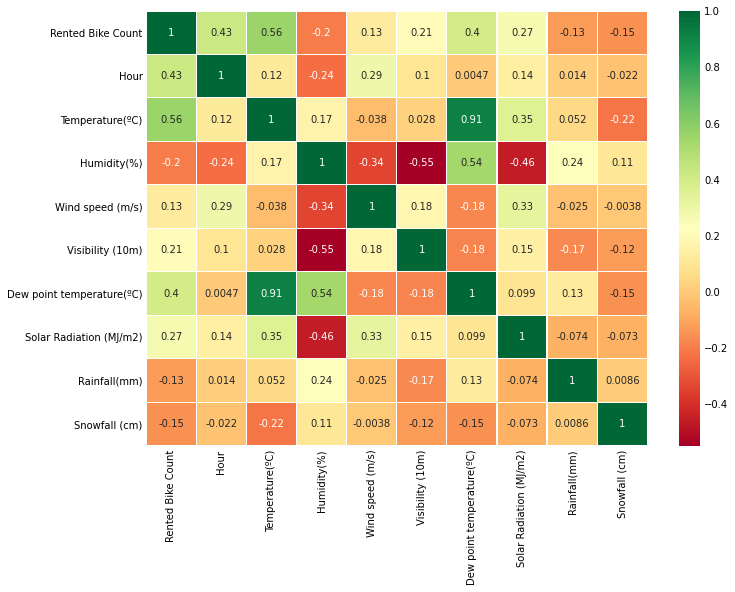

In [7]:
sns.heatmap(data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) 

fig=plt.gcf() # fig에 접근
fig.set_size_inches(10,8) # fig그림 크기 조절
plt.show()

변수들간의 상관관계가 높은 변수들은 다음과 같다.

- 이슬점 & 온도 : 0.91
- 가시거리 & 습도 : -0.55
- 이슬점 & 습도 : 0.54
- 자외선 지수 & 습도 : -0.46
- 자전거 대여(target) & 온도 : 0.56
- 자전거 대여(target) & 시간 : 0.43

이슬점 & 온도의 상관관계가 0.91로써 매우 높게 나왔다.


<의견>
1. 종속성이 높아 하나의 변수로 둘을 설명할 수 있으니 **한 변수를 제거해도 되지 않냐**는 의견이 나옴. 
2. 이 둘을 **PCA를 통해 하나의 변수로 생성**하면 되지 않냐는 의견이 나옴. 

이는 차후 결정을 해봐야 할 것으로 생각됨.

#### Seasons과 Holiday변수는 범주형 자료이므로 원핫인코딩을 적용

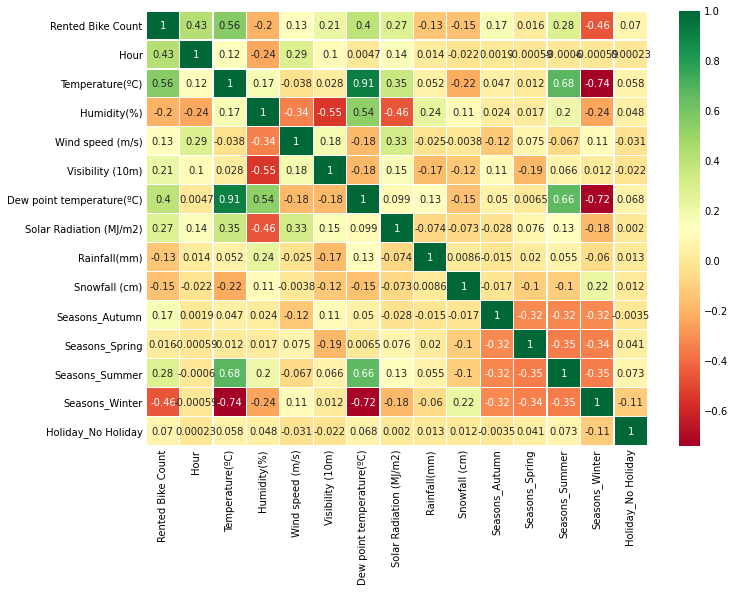

In [8]:
data.drop("Date",axis=1,inplace=True)
data1 = pd.get_dummies(data)
data1.drop("Holiday_Holiday",axis=1,inplace=True)

sns.heatmap(data1.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) 

fig=plt.gcf() # fig에 접근
fig.set_size_inches(10,8) # fig그림 크기 조절
plt.show()

seasons랑 holiday는 범주형 자료로서 분석에서 데이터로 고려될 경우 수치적 상관관계 혹은 분석 결과에 영향을 미칠 수도 있다.

연속형 자료들을 하나의 연산에 대입하는 회귀 분석에 사용되는 개념으로써 패턴을 학습하고 이를 바탕으로 결과를 예측하는 분류에는 적절하지 않을 수도 있다.

아직 본 데이터로 분류를 할 지 회귀를 할 지 타겟은 어떤 변수를 설정한 것인지 정하지 못한 상태이므로 seasons 변수랑 holiday 변수의 결과값을 1, 2, 3, 4랑 라벨 인코딩으로 변환하여 값을 비교해보기로 하였다.
(seasons - 1: spring, 2: summer, 3: fall, 4: winter / holiday - 0: no holiday, 1: holiday)

In [9]:
data['Seasons'].replace(['Spring','Summer','Autumn','Winter'],[1,2,3,4],inplace=True)
data['Holiday'].replace(['No Holiday','Holiday'],[0,1],inplace=True)

data.head()

,Rented Bike Count,Hour,Temperature(ºC),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(ºC),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,4,0
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,4,0
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,4,0
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,4,0
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,4,0


In [10]:
data.describe()

,Rented Bike Count,Hour,Temperature(ºC),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(ºC),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday
count,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.00000,8465.000000,8465.000000,8465.000000
mean,729.156999,11.507029,12.771057,58.147194,1.725883,1433.873479,3.944997,0.567868,0.14912,0.077685,2.483993,0.048198
std,642.351166,6.920899,12.104375,20.484839,1.034281,609.051229,13.242399,0.868245,1.12554,0.444063,1.127194,0.214198
min,2.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.00000,0.000000,1.000000,0.000000
25%,214.000000,6.000000,3.000000,42.000000,0.900000,935.000000,-5.100000,0.000000,0.00000,0.000000,1.000000,0.000000
50%,542.000000,12.000000,13.500000,57.000000,1.500000,1690.000000,4.700000,0.010000,0.00000,0.000000,2.000000,0.000000
75%,1084.000000,18.000000,22.700000,74.000000,2.300000,2000.000000,15.200000,0.930000,0.00000,0.000000,4.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.00000,8.800000,4.000000,1.000000


통계학에서는 결과값(정확도)과 변수와의 관계를 유의미하게 설명하는 것이 목표이다. 하지만 머신러닝은 정확도를 최대로 올리는 것이 목표이다.

정확도와 유의미한 설명을 위해 정확도를 포기해야 하는 것은 데이터 분석 과정 중에서 계속 유념하고 토론해야 될 사안으로 판단된다.

## Predictive Modeling

지도 학습에는 분류(Classification)와 회귀(Regression), 추천 시스템, 시각/음성 감지/인지, 텍스트 분석, NLP 등이 있다.

**분류**는 학습 데이터로 주어진 데이터의 피처와 레이블값을 머신러닝 알고리즘으로 학습해 모델을 생성한다. 이렇게 생성된 모델에 새로운 데이터 값이 주어졌을 때 미지의 레이블 값을 예측하는 것이다. 

**즉 기존 데이터가 어떤 레이블에 속하는지 패턴을 알고리즘으로 인지한 뒤에 새롭게 관측된 데이터에 대한 레이블을 판별하는 것이다.**

분류는 두 개로 분류하는 이진 분류(binary classification)과 셋 이상으로 분류하는 다중 분류(multiclass classification)으로 나누어 진다.

- 베이즈 통계와 생성모델에 기반한 나이브 베이즈
- 독립변수와 종속변수의 선형 관계성에 기반한 로지스틱 회귀
- 데이터 균일도에 따른 규칙 기반의 결정트리
- 개별 글래스 간의 최대 분류 마진을 효과적으로 찾아주는 서포트 벡터 머신
- 근접 거리를 기준으로 하는 최소 근접 알고리즘
- 심층 연결 기반의 신경망
- 서로 다른 머신러닝 알고리즘을 결합한 앙상블

**회귀**는 데이터 값이 평균과 같은 일정한 값으로 돌아가려는 경향을 이용한 통계학 기법으로 머신러닝 회귀 예측의 핵심은 **주어진 피처와 결정 값 데이터 기반에서 학습을 통해 최적에 회귀 계수를 찾아내는 것이다.**

최적의 선형 함수를 찾기 위해 실제값과 예측값 차이의 제곱을 회귀 계수 W를 변수로 하는 비용함수로 만들고, 이 비용 함수가 최소화되는 W의 값을 찾아 선형 함수를 도출한다. 그리고 이 비용 함수(손실 함수)를 최소화 할 수 있는 방법으로 경사하강법을 사용한다.

경사하강법 : 반복적으로 비용 함수의 반환 값, 즉 예측값과 살제 값의 차이가 작아지는 방향성을 가지고 W 파라미터를 지속해서 보정해 나간다. 그리고 오류 값이 더 이상 작아지지 않으면 그 오류 값을 최소 비용으로 판단하고 그때의 W 값을 최적 파라미터로 반환하는 방법이다.

선형 모델을 기반으로 하는 선형 회귀는 데이터 값의 분포도와 인코딩 방법에 많은 영향을 받을 수 있다. 선형 회귀는 데이터 값의 분포도가 정규 분포와 같은 형태를 선호하며, 특히 타겟값의 분포가 왜곡 되지 않고 정규 분포 형태로 되어야 예측 성능을 저하시키지 않는다.

[왜곡된 데이터 -> 로그변환 / 카테고리형 데이터 -> 원-핫 인코딩(회귀트리의 경우 인코딩 방식에 크게 영향을 받지 않음)]

<단순 선형 회귀 종류>
- 일반 선형 회귀 : 예측값과 실제 값으 RSS를 최소화할 수 있도록 회귀 계수를 최적화하며, 규제를 적용하지 않은 모델이다.
- 릿지 : 릿지 회귀는 선형 회귀에 L2 규제를 추가한 회귀모델이다. 릿지 회귀는 L2 규제를 적용하는데, **L2 규제는 상대적으로 큰 회귀 계수 값의 예측 영향도를 감소시키기 위해서 회귀 계수값을 더 작게 만드는 규제모델이다.**
- 라쏘 : 라쏘 회귀는 선형 회귀에 L1 규제를 적용한 방식이다. L2 규제가 회귀 계수 값의 크기를 줄이는 데 반해, **L1 규제는 예측 영향력이 작은 피처의 회귀 계수를 0으로 만들어 회귀 예측 시 피처가 선택되지 않게 하는 것이다.** 이러한 특성 때문에 L1 규제는 피처 선택 기능으로도 불린다.
- 엘라스틱넷 : L2, L1 규제를 함께 결합한 모델이다. 주로 **피처가 많은 데이터 세트에서 적용**되며, L1 규제로 피처의 개수를 줄임과 동시에 L2 규제로 계수 값의 크기를 조정한다.
- 로지스틱 회귀 : 로지스틱 회귀는 회귀라는 이름이 붙어 있지만, 사실은 **분류에 사용되는 선형 모델**이다. 로지스틱 회귀는 매우 강력한 분류 알고리즘이다. 일반적으로 이진 분류뿐만 아니라 희소 영역의 분류, 예를들어 텍스트 분류와 같은 영역에서 뛰어난 예측 성능을 보인다.

<단순 선형 회귀 이외에도 다음과 같은 방법들이 있다.>
- 회귀가 독립변수의 단항식이 아닌 2차, 3차 방정식과 같은 다항식으로 표현되는 **다항 회귀**
- 회귀를 위한 트리를 생성하고 이를 기반으로 회귀 예측을 하는 **회귀트리** (리프 노드에 속한 데이터 값의 평균값을 구해 회귀 예측값을 계산)

<회귀의 평가지표>
- MAE : Mean Absolute Error. 실제 값과 예측값의 차이를 절대값으로 변환해 평균한 것
- MSE : Mean Squared Error. 실제 값과 예측값의 차이를 제곱해 평균한 것
- RMSE : MSE에 루트를 씌운 것 (MSE 값은 오류의 제곱을 구하므로 실제 오류 평균보다 더 커지는 특성이 있음)
- $R^2$ : 분산 기반으로 예측 성능을 평가. 실제 값의 분산 대비 예측값의 분산 비율을 지표로 하며, 1에 가까울수록 예측 정확도가 높다.
- MSLE : MSE에 로그를 적용한 것
- RMSLE : RMSE에 로그를 적용한 것


본 분석으로 넘어와서 target값을 Rented Bike Count변수를 목표로 정하였다. 

이 때 연속적인 숫자(실수)를 예측하므로 출력 값에 연속성이 있다면 회귀 문제라고 볼 수 있다.

우리가 구하고자하는 target값인 Rented Bike Count는 이산형으로 수치형 자료이다.
따라서 분류보다는 회귀모델을 적용시켜 분석하는 것이 바람직하다.

이를 위해서 라벨 인코딩보다는 원핫 인코딩이 범주형 자료를 수치적으로 잘 표현했다고 판단했고 이 데이터를 사용하기로 한다.

먼저 회귀 모델 적용에 앞서 회귀는 데이터가 가우시안 분포를 가지고 있다고 가정하고 구현됐기 때문에 사전에 표준화를 적용시켜준다.

In [11]:
# StandardScaler객체 생성
scaler = StandardScaler()
# StandardScaler로 데이터 세트 변환. fit()과 transform() 호출.
scaler.fit(data1)
data_scale = scaler.transform(data1)
data_scale=pd.DataFrame(data=data_scale,columns=data1.columns)

data_scale.head()

,Rented Bike Count,Hour,Temperature(ºC),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(ºC),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_No Holiday
0,-0.739759,-1.662748,-1.484762,-1.032395,0.458429,0.929577,-1.627067,-0.654079,-0.132495,-0.174951,-0.544722,-0.585308,-0.594041,1.708503,0.225032
1,-0.817603,-1.518249,-1.509548,-0.983575,-0.895248,0.929577,-1.627067,-0.654079,-0.132495,-0.174951,-0.544722,-0.585308,-0.594041,1.708503,0.225032
2,-0.865866,-1.373751,-1.550858,-0.934756,-0.701865,0.929577,-1.634619,-0.654079,-0.132495,-0.174951,-0.544722,-0.585308,-0.594041,1.708503,0.225032
3,-0.968619,-1.229252,-1.567382,-0.885937,-0.798556,0.929577,-1.627067,-0.654079,-0.132495,-0.174951,-0.544722,-0.585308,-0.594041,1.708503,0.225032
4,-1.013769,-1.084754,-1.550858,-1.081214,0.555121,0.929577,-1.702586,-0.654079,-0.132495,-0.174951,-0.544722,-0.585308,-0.594041,1.708503,0.225032


In [12]:
data_log=np.log1p(data)

data_log.head()

,Rented Bike Count,Hour,Temperature(ºC),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(ºC),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday
0,5.541264,0.000000,NaN,3.637586,1.163151,7.601402,NaN,0.0,0.0,0.0,1.609438,0.0
1,5.323010,0.693147,NaN,3.663562,0.587787,7.601402,NaN,0.0,0.0,0.0,1.609438,0.0
2,5.159055,1.098612,NaN,3.688879,0.693147,7.601402,NaN,0.0,0.0,0.0,1.609438,0.0
3,4.682131,1.386294,NaN,3.713572,0.641854,7.601402,NaN,0.0,0.0,0.0,1.609438,0.0
4,4.369448,1.609438,NaN,3.610918,1.193922,7.601402,NaN,0.0,0.0,0.0,1.609438,0.0


온도와 관련된 변수에서 음수값이 존재하므로 로그변환을 했을 경우 결측치가 생기게 된다. 단위를 섭씨가 아닌 화씨로 바꾸어도 마찬가지였기 때문에 이러한 점에서 회귀 기법을 위한 표준화를 로그변환이 아닌 StandardScaler함수를 사용하여 표준화시킨다.

### 단순선형회귀

In [13]:
y_target_scale = data_scale['Rented Bike Count']
X_data_scale = data_scale.drop(['Rented Bike Count'], axis=1,inplace=False)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_data_scale, y_target_scale,
                                                    test_size=0.2, random_state=0)

In [15]:
# 선형 회귀와 결정 트리 기반의 Regressor 생성. DecisionTreeRegressor의 max_depth는 각각 2, 7
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)
print(rmse)

0.6712275112864038


피처값은 총 12개로 Rented Bike Count에 큰 영향을 미치지 않는 변수들을 제거하여 학습속도를 조금 더 높이고자한다.

이 때 target값과 상관관계가 낮은 변수들이 큰 의미가 없다고 가정하여 이 변수를 제거해야할지
피처간 상관관계가 높은 즉, 하나의 변수로도 두가지의 변수를 설명할수있는 피처를 제거해야할지 의문이 든다.

target값과 상관관계가 낮은 변수인 "Holiday","Wind speed (m/s)","Rainfall(mm)"를 제거하고
피처간 상관관계가 높은 Dew point temperature(ºC)와 Temperature중 target값과의 상관관계가 낮은 Dew point temperature(ºC)을 제거하여 이들의 rmse를 비교하고자 한다.

In [16]:
data_scale2=data_scale.drop(["Holiday_No Holiday","Wind speed (m/s)","Rainfall(mm)"],axis=1,inplace=False)

y_target_scale = data_scale2['Rented Bike Count']
X_data_scale = data_scale2.drop(['Rented Bike Count'], axis=1,inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_data_scale, y_target_scale,
                                                    test_size=0.2, random_state=0)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)
print(rmse)

0.6811268051145509


In [17]:
data_scale.describe()

,Rented Bike Count,Hour,Temperature(ºC),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(ºC),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_No Holiday
count,8.465000e+03,8.465000e+03,8.465000e+03,8.465000e+03,8.465000e+03,8.465000e+03,8.465000e+03,8.465000e+03,8.465000e+03,8.465000e+03,8.465000e+03,8.465000e+03,8.465000e+03,8.465000e+03,8.465000e+03
mean,-7.353834e-16,1.812031e-16,1.462111e-15,-2.586367e-17,7.423084e-16,9.662678e-16,-1.307506e-15,-4.115104e-15,-1.304207e-15,-7.366497e-15,4.574098e-14,1.734702e-15,1.830812e-15,6.872465e-14,2.136560e-15
std,1.000059e+00,1.000059e+00,1.000059e+00,1.000059e+00,1.000059e+00,1.000059e+00,1.000059e+00,1.000059e+00,1.000059e+00,1.000059e+00,1.000059e+00,1.000059e+00,1.000059e+00,1.000059e+00,1.000059e+00
min,-1.132091e+00,-1.662748e+00,-2.525770e+00,-2.838716e+00,-1.668777e+00,-2.310079e+00,-2.608820e+00,-6.540793e-01,-1.324953e-01,-1.749507e-01,-5.447218e-01,-5.853078e-01,-5.940410e-01,-5.853078e-01,-4.443821e+00
25%,-8.020339e-01,-7.957570e-01,-8.072812e-01,-7.882976e-01,-7.985564e-01,-8.191478e-01,-6.830735e-01,-6.540793e-01,-1.324953e-01,-1.749507e-01,-5.447218e-01,-5.853078e-01,-5.940410e-01,-5.853078e-01,2.250315e-01
50%,-2.913796e-01,7.123354e-02,6.022498e-02,-5.600543e-02,-2.184091e-01,4.205585e-01,5.701743e-02,-6.425612e-01,-1.324953e-01,-1.749507e-01,-5.447218e-01,-5.853078e-01,-5.940410e-01,-5.853078e-01,2.250315e-01
75%,5.524454e-01,9.382241e-01,8.203257e-01,7.739257e-01,5.551207e-01,9.295769e-01,8.499720e-01,4.171099e-01,-1.324953e-01,-1.749507e-01,-5.447218e-01,1.708503e+00,1.683385e+00,1.708503e+00,2.250315e-01
max,4.401035e+00,1.660716e+00,2.200074e+00,1.945593e+00,5.486373e+00,9.295769e-01,1.756206e+00,3.400314e+00,3.096553e+01,1.964322e+01,1.835800e+00,1.708503e+00,1.683385e+00,1.708503e+00,2.250315e-01


In [18]:
data_scale1=data_scale.drop(["Dew point temperature(ºC)"],axis=1,inplace=False)

y_target_scale = data_scale1['Rented Bike Count']
X_data_scale = data_scale1.drop(['Rented Bike Count'], axis=1,inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_data_scale, y_target_scale,
                                                    test_size=0.2, random_state=0)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)
print(rmse)

0.6707045772440292


피처간 상관관계가 높은 Dew point temperature(ºC)를 제거하였을때가 rmse의 값의 변화가 적었고 변수를 제거하지 않았을때보다 미미하지만 rmse의 값이 더 줄었음을 알수있다.

#### 릿지회귀

In [19]:
###########   릿지회귀
########data_scale1 사용

data_scale1=data_scale.drop(["Dew point temperature(ºC)"],axis=1,inplace=False)

y_target_scale = data_scale1['Rented Bike Count']
X_data_scale = data_scale1.drop(['Rented Bike Count'], axis=1,inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_data_scale, y_target_scale,
                                                    test_size=0.2, random_state=0)

# alpha를 최적값
regr_cv = RidgeCV(alphas=[0.01,0.05,0.1,0.15,0.5,1.0,10,11,12,15,20,30,40,50])
model_cv = regr_cv.fit(X_data_scale,y_target_scale)
#계수 확인
model_cv.coef_
#alpha
model_cv.alpha_

10.0

현재까지는 RMSE 최적합을 위한 모델을 만들었으나, 과적합을 방지하기 위해서 릿지와 라쏘 규제를 사용하기로 했다. 릿지 회귀에서는 교차검증에 의한 최적의 계수가 10인 것으로 나타났다.

#### 라쏘회귀

In [20]:
####### 라소 회귀에서의 alpha 최적값 찾기(쿡북 참조)

#세 개의 alpha 값에 대한 라소 회귀를 만듭니다
lasso_cv = LassoCV(alphas=[0.01,0.03,0.05,0.1,0.15,0.5,1.0,10,11,12,15,20,30,40,50],cv=5)

#선형 회귀 모델을 훈련
model_cv = lasso_cv.fit(X_data_scale,y_target_scale)
#계수를 확인
model_cv.coef_
#alpha 확인
model_cv.alpha_

0.05

라소 회귀에서는 alpha 최적값이 0.05가 나왔다.

In [21]:
#라쏘 회귀 실행(최적 alpha)
lasso=Lasso(alpha=0.05)
neg_mse_scores = cross_val_score(lasso, X_test, y_test, scoring='neg_mean_squared_error',cv=5)
avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
print('RMSE:',avg_rmse)

RMSE: 0.6841510936509763


라쏘 회귀는 RMSE뿐만 아니라 비용함수를 고려한 L1규제에 의해서 회귀계수 벡터의 크기도 고려해주기 때문에 선형회귀모델 간 다른 결과 값이 나온다. 

그러므로 RMSE의 비중이 줄어들기 때문에 RMSE의 값이 더 커진다.

In [22]:
#10로 릿지
ridge = Ridge(alpha=10)
neg_mse_scores = cross_val_score(ridge,X_data_scale,y_target_scale,scoring='neg_mean_squared_error',cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)
print('개별 RMSE:',np.round(rmse_scores,3))
print('평균 RMSE:{0:.3f}'.format(avg_rmse))

개별 RMSE: [0.508 0.606 1.006 1.046 0.676]
평균 RMSE:0.769


### 회귀트리

In [23]:
########회귀트리
#결정 회귀 트리, RandomForeset 회귀트리, GradientBoosting 회귀트리, XGB 회귀트리, LGBM회귀 트리

# 교차검증으로 평균 RMSE를 계산해주는 함수 
def get_model_cv_prediction(model, X_data_scale,y_target_scale):
    neg_mse_scores = cross_val_score(model,X_data_scale,y_target_scale,scoring='neg_mean_squared_error',cv=5)
    rmse_scores = np.sqrt(-1*neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print('####',model.__class__.__name__, '####')
    print('5교차 검증의 평균 RMSE:',avg_rmse)

dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=100)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=100)
xgb_reg = XGBRegressor(n_estimators=100)
lgb_reg = LGBMRegressor(n_estimators=100)

models =[dt_reg,rf_reg,gb_reg,xgb_reg,lgb_reg]

for model in models :
    get_model_cv_prediction(model, X_data_scale,y_target_scale)
    for i in notebook.tqdm(range(100), desc='iterate range 100'):
        time.sleep(0.01)

#### DecisionTreeRegressor ####
5교차 검증의 평균 RMSE: 0.6092750307056446



#### RandomForestRegressor ####
5교차 검증의 평균 RMSE: 0.5031864145799603



#### GradientBoostingRegressor ####
5교차 검증의 평균 RMSE: 0.4911195795570643



#### XGBRegressor ####
5교차 검증의 평균 RMSE: 0.5071373653829644



#### LGBMRegressor ####
5교차 검증의 평균 RMSE: nan


결정트리 모델 기반의 회귀분석을 적용하였더니 기존의 선형회귀 분석보다 더 좋은 결과가 나왔다.
이는 수식을 바탕으로 하는 모델보다 회귀트리 규칙을 이용한 모델의 성능이 더 뛰어남을 나타낸다. 즉, 서울 자전거 수요 데이터에서는 수식보다는 규칙에 의한 분석이 더 적합하다고 볼 수 있다.

In [24]:
lgb_reg = LGBMRegressor(n_estimators=100)
get_model_cv_prediction(lgb_reg, X_data_scale,y_target_scale)

#### LGBMRegressor ####
5교차 검증의 평균 RMSE: nan


In [25]:
neg_mse_scores = cross_val_score(lgb_reg,X_data_scale,y_target_scale,scoring='neg_mean_squared_error',cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)
print(avg_rmse)

nan


In [26]:
lgb_reg = LGBMRegressor(n_estimators=100)
model = lgb_reg.fit(X_data_scale,y_target_scale)

LightGBMError: Do not support non-ASCII characters in feature name.

시간이 된다면 LGBM트리에서 nan 값이 나오는 이유를 알아볼 필요가 있다.

-> Do not support non-ASCII characters in feature name. 피처이름에서 쓰여진 문자 때문에 에러가 발생한듯하다.

In [27]:
X_data_scale=X_data_scale.rename({'Dew point temperature(ºC)':'Dew point temperature','Temperature(ºC)':'Temperature'}, axis='columns')

In [28]:
########회귀트리
#결정 회귀 트리, RandomForeset 회귀트리, GradientBoosting 회귀트리, XGB 회귀트리, LGBM회귀 트리

# 교차검증으로 평균 RMSE를 계산해주는 함수 
def get_model_cv_prediction(model, X_data_scale,y_target_scale):
    neg_mse_scores = cross_val_score(model,X_data_scale,y_target_scale,scoring='neg_mean_squared_error',cv=5)
    rmse_scores = np.sqrt(-1*neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print('####',model.__class__.__name__, '####')
    print('5교차 검증의 평균 RMSE:',avg_rmse)

dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=100)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=100)
xgb_reg = XGBRegressor(n_estimators=100)
lgb_reg = LGBMRegressor(n_estimators=100)

models =[dt_reg,rf_reg,gb_reg,xgb_reg,lgb_reg]

for model in models :
    get_model_cv_prediction(model, X_data_scale,y_target_scale)
    for i in notebook.tqdm(range(100), desc='iterate range 100'):
        time.sleep(0.01)

#### DecisionTreeRegressor ####
5교차 검증의 평균 RMSE: 0.6092750307056446



#### RandomForestRegressor ####
5교차 검증의 평균 RMSE: 0.5031864145799603



#### GradientBoostingRegressor ####
5교차 검증의 평균 RMSE: 0.4911195795570643



#### XGBRegressor ####
5교차 검증의 평균 RMSE: 0.5071373653829644



#### LGBMRegressor ####
5교차 검증의 평균 RMSE: 0.462650911523882


LGBMRegressor에서 가장 낮은 RMSE 값인 0.462650911523882이 나왔다.

## Dimension Reduction

차원축소 : 매우 많은 피처로 구성된 다차원 데이터 세트의 차원을 축소해 새로운 차원의 데이터 세트를 생성하는 것

수백 개 이상의 피처로 구성된 데이터 세트의 경우 상대적으로 적은 차원에서 학습된 모델보다 예측 신뢰도가 떨어진다. 또한 피처가 많을 경우 개별 피처간에 산관관계가 높을 가능성이 크다. 선형 회귀와 같은 선형 모델에서는 입력 변수 간의 상관간계가 높을경우 다중 공선성 문제로 예측 성능이 저하된다. 이런 문제들을 해결하기 위해 차원축소가 한 가지의 해결방법으로 사용되곤한다.

주로 이미지나 텍스트에서 차원 축소를 통해 잠재적인 의미를 찾는다. <- 이미지 분류 등의 수행 시에 과적합 영향력이 작아져서 원본 데이터로 예측하는 것보다 예측 성능을 더 끌어 올릴 수 있다.

- 피처선택 : 특정 피처에 종속성이 강한 불필요한 피처는 아예 제거하고, 데이터의 특징을 잘 나타내는 주요 피처만 선택하는 것
- 피처추출 : 기존 피처를 저차원의 중요 피처로 압축해서 추출

<대표적인 차원축소 알고리즘>
- PCA : 여러 변수 간에 존재하는 상관관계를 이용해 이를 대표하는 주성분을 추출해 차원을 축소하는 기법
    1. 입력 데이터 세트의 공분산 행렬을 생성
    2. **공분산 행렬의 고유벡터와 고유값을 계산**
    3. 고유값이 가장 큰 순으로 K개(PCA 변환 차수만큼)만큼 고유벡터를 추출
    4. 고유값이 가장 큰 순 으로 추출된 고유벡터를 이용해 새롭게 입력 데이터를 변환
    
    
- LDA : 선형 판별 분석법 (공분산행렬이 동질, 다변량 정규성 만족할 때 사용). 

    입력 데이터 세트를 저차원 공간에 투영해 차원을 축소하는 기법이지만, **지도학습의 분류**에서 사용하기 쉽도록 개별 클래스를 분별할 수 있는 기준을 최대한 유지하면서 차원을 축소한다. 
    
    **클래스 간 분산은 최대한 크게 가져가고, 클래스 내부의 분산은 최대한 작게 가져가는 방식**으로 클래스를 분리한다.
    
    
- SVD : 정방행렬뿐만 아니라 행과 열의 크기가 다른 행렬에도 적용할 수 있는 차원 축소 방법 (특이값 분해)

- NMF : 낮은 랭크를 통한 행렬 근사방식의 변형

본 데이터는 피처의 수는 작지만 실습을 해보는 것이 목적이므로 차원축소를 진행해보고자 한다.

### PCA

In [29]:
pca = PCA(n_components=5)

#fit( )과 transform( ) 을 호출하여 PCA 변환 데이터 반환
pca.fit(X_data_scale)
data_pca = pca.transform(X_data_scale)
print(data_pca.shape)

(8465, 5)


In [30]:
print(pca.explained_variance_ratio_)

[0.18842267 0.17247313 0.11337739 0.10396837 0.08440606]


In [31]:
pca_columns=['pca_component_1','pca_component_2','pca_component_3','pca_component_4','pca_component_5']
data_pca = pd.DataFrame(data_pca, columns=pca_columns)
pca_x = data_pca[['pca_component_1','pca_component_2','pca_component_3','pca_component_4','pca_component_5']]
gb_reg_pca = GradientBoostingRegressor(random_state=0, n_estimators=100)

get_model_cv_prediction(gb_reg_pca, pca_x, y_target_scale)
for i in notebook.tqdm(range(100), desc='iterate range 100'):
        time.sleep(0.01)

#### GradientBoostingRegressor ####
5교차 검증의 평균 RMSE: 0.6902539407937899


회귀분석의 경우 변수들간의 독립성을 기본 전제로 하는 분석방법이다.

PCA 분석 결과 기존 RMSE보다는 많은 시간이 줄어들었다.

### LDA

In [32]:
# StandardScaler객체 생성
scaler = StandardScaler()
# StandardScaler로 데이터 세트 변환. fit()과 transform() 호출.
scaler.fit(data)
data_scale_l = scaler.transform(data)
data_scale_l=pd.DataFrame(data=data_scale_l,columns=data.columns)

data_scale_l.head()

,Rented Bike Count,Hour,Temperature(ºC),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(ºC),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday
0,-0.739759,-1.662748,-1.484762,-1.032395,0.458429,0.929577,-1.627067,-0.654079,-0.132495,-0.174951,1.345018,-0.225032
1,-0.817603,-1.518249,-1.509548,-0.983575,-0.895248,0.929577,-1.627067,-0.654079,-0.132495,-0.174951,1.345018,-0.225032
2,-0.865866,-1.373751,-1.550858,-0.934756,-0.701865,0.929577,-1.634619,-0.654079,-0.132495,-0.174951,1.345018,-0.225032
3,-0.968619,-1.229252,-1.567382,-0.885937,-0.798556,0.929577,-1.627067,-0.654079,-0.132495,-0.174951,1.345018,-0.225032
4,-1.013769,-1.084754,-1.550858,-1.081214,0.555121,0.929577,-1.702586,-0.654079,-0.132495,-0.174951,1.345018,-0.225032


In [33]:
data_scale_l=data_scale_l.drop(["Dew point temperature(ºC)"],axis=1,inplace=False)

y_target_scale_l = data_scale_l['Rented Bike Count']
X_data_scale_l = data_scale_l.drop(['Rented Bike Count'], axis=1,inplace=False)

X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_data_scale_l, y_target_scale_l,
                                                    test_size=0.2, random_state=0)

In [34]:
lda = LinearDiscriminantAnalysis(n_components=5)
lda.fit(data_scale_l, y_target_scale_l)
data_lda = lda.transform(data_scale_l)
print(data_lda.shape)

ValueError: Unknown label type: (array([-0.73975902, -0.81760266, -0.86586572, ..., -0.05473498,
       -0.02671127, -0.22599099]),)

LDA 는 지도학습의 분류에서 사용하기 쉽도록 개별 클래스를 분별할 수 있는 기준을 최대한 유지하면서 차원을 축소합니다.
본 데이터에선 개별 클래스를 분별할 수 있는 기준이 없으므로 차원축소를 생략합니다.

근데 LDA 왜 안됨?? -> 본 분석은 회귀 모델으로 분류에 적합한 LDA은 본 분석에 적합하지 않다. Target을 'Rented Bike Count'가 아닌 'Season' 이나 'Holiday'으로 바꾸어 분석을 하면 문제가 없을 것이다. 여기서 LDA는 생략하도록 한다.

In [35]:
data_scale

,Rented Bike Count,Hour,Temperature(ºC),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(ºC),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_No Holiday
0,-0.739759,-1.662748,-1.484762,-1.032395,0.458429,0.929577,-1.627067,-0.654079,-0.132495,-0.174951,-0.544722,-0.585308,-0.594041,1.708503,0.225032
1,-0.817603,-1.518249,-1.509548,-0.983575,-0.895248,0.929577,-1.627067,-0.654079,-0.132495,-0.174951,-0.544722,-0.585308,-0.594041,1.708503,0.225032
2,-0.865866,-1.373751,-1.550858,-0.934756,-0.701865,0.929577,-1.634619,-0.654079,-0.132495,-0.174951,-0.544722,-0.585308,-0.594041,1.708503,0.225032
3,-0.968619,-1.229252,-1.567382,-0.885937,-0.798556,0.929577,-1.627067,-0.654079,-0.132495,-0.174951,-0.544722,-0.585308,-0.594041,1.708503,0.225032
4,-1.013769,-1.084754,-1.550858,-1.081214,0.555121,0.929577,-1.702586,-0.654079,-0.132495,-0.174951,-0.544722,-0.585308,-0.594041,1.708503,0.225032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8460,0.426339,1.082723,-0.708138,-1.178853,0.845194,0.755525,-1.075775,-0.654079,-0.132495,-0.174951,1.835800,-0.585308,-0.594041,-0.585308,0.225032
8461,0.054246,1.227221,-0.774233,-1.032395,0.555121,0.929577,-1.045567,-0.654079,-0.132495,-0.174951,1.835800,-0.585308,-0.594041,-0.585308,0.225032
8462,-0.054735,1.371719,-0.840329,-0.934756,-1.378704,0.877033,-1.045567,-0.654079,-0.132495,-0.174951,1.835800,-0.585308,-0.594041,-0.585308,0.225032
8463,-0.026711,1.516218,-0.881639,-0.837117,-0.701865,0.698056,-1.038015,-0.654079,-0.132495,-0.174951,1.835800,-0.585308,-0.594041,-0.585308,0.225032


### SVD

In [36]:
tsvd = TruncatedSVD(n_components=5)
tsvd.fit(X_data_scale)
data_tsvd = tsvd.transform(X_data_scale)

In [37]:
gb_reg_tsvd = GradientBoostingRegressor(random_state=0, n_estimators=100)

get_model_cv_prediction(gb_reg_tsvd, data_tsvd, y_target_scale)

#### GradientBoostingRegressor ####
5교차 검증의 평균 RMSE: 0.6902539407937899


## 스태킹

### 기본 스태킹

In [38]:
# 개별 ML 모델을 위한 Classifier 생성.
li_reg = LinearRegression()
dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=100)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=100)
xgb_reg = XGBRegressor(n_estimators=100)

# 최종 Stacking 모델을 위한 Classifier생성. 
lr_final = GradientBoostingRegressor(random_state=0, n_estimators=100)

# 개별 모델들을 학습. 
li_reg.fit(X_train, y_train)
dt_reg.fit(X_train, y_train)
rf_reg.fit(X_train , y_train)
gb_reg.fit(X_train , y_train)
xgb_reg.fit(X_train, y_train)

# 학습된 개별 모델들이 각자 반환하는 예측 데이터 셋을 생성하고 개별 모델의 정확도 측정. 
li_pred = li_reg.predict(X_test)
dt_pred = dt_reg.predict(X_test)
rf_pred = rf_reg.predict(X_test)
gb_pred = gb_reg.predict(X_test)
xgb_pred = xgb_reg.predict(X_test)

print('LinearRegression rmse: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, li_pred))))
print('DecisionTree rmse: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, dt_pred))))
print('RandomForest rmse: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, rf_pred))))
print('GradientBoosting rmse: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, gb_pred))))
print('XGB rmse: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, xgb_pred))))

LinearRegression rmse: 0.6707
DecisionTree rmse: 0.5606
RandomForest rmse: 0.3797
GradientBoosting rmse: 0.4036
XGB rmse: 0.3708


In [39]:
pred = np.array([li_pred, dt_pred, rf_pred, gb_pred, xgb_pred])
pred = np.transpose(pred)

lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 rmse: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, final))))

최종 메타 모델의 rmse: 0.2827


스태킹은 개별 알고리즘의 예측 경로가 데이터 세트를 최종적인 메타 데이터 세트로 만들어 별도의 ML 알고리즘으로 최종학습을 수행하고 테스트 데이터를 기반으로 다시 최종 예측을 수행하는 모델 학습 기법이다.

개별 알고리즘은 앞에서 사용하였던 LinearRegression, DecisionTree, RandomForest, GradientBoosting, XGB으로 총 5개를 지정하였고
최종 메타모델은 이전 CV결과에서 가장 낮은 rmse를 가진 GradientBoosting 모델로 설정하였다.

결과적으로 스태킹을 한 모델에서 최종 rmse가 지금 까지의 결과 중 가장 낮았다.

개별 결과값이 다른 이유는 앞선 CV모델과 달리 CV를 적용 하지않고 train test로 split하여 모델학습을 시켰기 때문에 조금의 차이를 보인다.
여기서 이 모델별로 도출된 예측 레이블 값을 다시 합쳐서 스태킹된 데이터 세트에 대해 최종 모델인 GradientBoosting을 적용했기 때문에 즉, 이러한 조합을 통해 서로의 장점은 취하고 약점을 보완할 수 있었다.

하지만 이러한 스태킹 기법으로 예측을 한다고 무조건 개별 모델보다는 좋아진다는 보장은 없다.
따라서 최종 메타모델의 선택이나 개별 모델 선택 그리고 개별 하이퍼 파라미터 설정이 중요하다.

### CV를 활용한 스태킹

In [40]:
# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [41]:
# get_stacking_base_datasets( )은 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환. 
# classfication에서는 이 과정이 필요없으나 회귀에서는 이 배열 변환이 필수적임
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values


# 각 개별 기반(Base)모델이 생성한 학습용/테스트용 데이터 반환. 
li_train, li_test = get_stacking_base_datasets(li_reg, X_train_n, y_train_n, X_test_n, 5)
dt_train, dt_test = get_stacking_base_datasets(dt_reg, X_train_n, y_train_n, X_test_n, 5)
rf_train, rf_test = get_stacking_base_datasets(rf_reg, X_train_n, y_train_n, X_test_n, 5)  
gb_train, gb_test = get_stacking_base_datasets(gb_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)

LinearRegression  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
DecisionTreeRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
RandomForestRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
GradientBoostingRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 


In [42]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 Stacking 형태로 결합.  
Stack_final_X_train = np.concatenate((li_train, dt_train, rf_train, gb_train, xgb_train), axis=1)
Stack_final_X_test = np.concatenate((li_test, dt_test, rf_test, gb_test, xgb_test), axis=1)

# 최종 메타 모델은 GradientBoostingRegressor 모델을 적용. 
meta_model_gb = GradientBoostingRegressor(random_state=0, n_estimators=100)

#기반 모델의 예측값을 기반으로 새롭게 만들어진 학습 및 테스트용 데이터로 예측하고 RMSE 측정.
meta_model_gb.fit(Stack_final_X_train, y_train)
final = meta_model_gb.predict(Stack_final_X_test)
mse = mean_squared_error(y_test , final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)

스태킹 회귀 모델의 최종 RMSE 값은: 0.37204646909445266


기본 스태킹에서 스태킹을 하는 1차 예측값을 설정하는 과정에서 test data를 사용하기 때문에 과적합의 문제가 발생할수있다.
이를 보완한 기법이 CV를 활용한 스태킹방법으로 앞선 방법에 비해 RMSE는 커졌지만 과적합 문제를 해결할수있다는 장점이 있다.

전체적으로 개별모델을 사용하는 것보다 스태킹 방법을 사용했을 때의 RMSE가 낮아졌다.

## 군집화

### K-Mean

본 데이터는 타겟값이 수치형 데이터이며 범주형 변수는 Seasons, Hour, Holiday가 있다.

군집화를 위해선 군집을 나누는 기준이 있어야하며, 쉽게 데이터를 파악하기 위해 PCA등 차원축소로 그래프를 통한 해석이 일반적이다.

위의 PCA결과 2개의 주성분으로 나누어 본 데이터를 설명하는데에는 큰 한계가 있다. 그러므로 차원 축소를 통한 그래프를 그리는 것보다는 타겟값과 상관계수가 높은 Hour 변수로 군집을 나누어 데이터 군집화를 보고자 한다.(Sesons_winter는 0,1으로 2개의 군집으로 나눠지기 때문에 그리고 원핫인코딩을 한 변수이기 때문에 고려하지 않음)

In [43]:
data_df= pd.DataFrame(data=data)

kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300,random_state=0).fit(data_df)

kmeans.fit(data_df)

data_df['target'] = data['Seasons']
data_df['cluster'] = kmeans.labels_
data_result = data_df.groupby(['target','cluster'])['Seasons'].count()
print(data_result)

target  cluster
1       0           878
        1           511
        2           518
        3           253
2       0           508
        1           734
        2           488
        3           478
3       0           445
        1           730
        2           482
        3           280
4       0           677
        1            20
        2          1463
Name: Seasons, dtype: int64


In [44]:
# 모든 개별 데이터에 실루엣 계수값을 구함. 
score_samples = silhouette_samples(data, data_df['cluster'])
print('silhouette_samples( ) return 값의 shape' , score_samples.shape)

# irisDF에 실루엣 계수 컬럼 추가
data_df['silhouette_coeff'] = score_samples

# 모든 데이터의 평균 실루엣 계수값을 구함. 
average_score = silhouette_score(data, data_df['cluster'])
print('data의 seasons별 Silhouette Analysis Score:{0:.3f}'.format(average_score))

print(data_df.groupby('cluster')['silhouette_coeff'].mean())

silhouette_samples( ) return 값의 shape (8465,)
data의 seasons별 Silhouette Analysis Score:0.461
cluster
0    0.482672
1    0.378655
2    0.544402
3    0.328998
Name: silhouette_coeff, dtype: float64


Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.7049787496083262
For n_clusters = 3 The average silhouette_score is : 0.5882004012129721
For n_clusters = 4 The average silhouette_score is : 0.6505186632729437
For n_clusters = 5 The average silhouette_score is : 0.5745566973301872
For n_clusters = 6 The average silhouette_score is : 0.4387644975296138


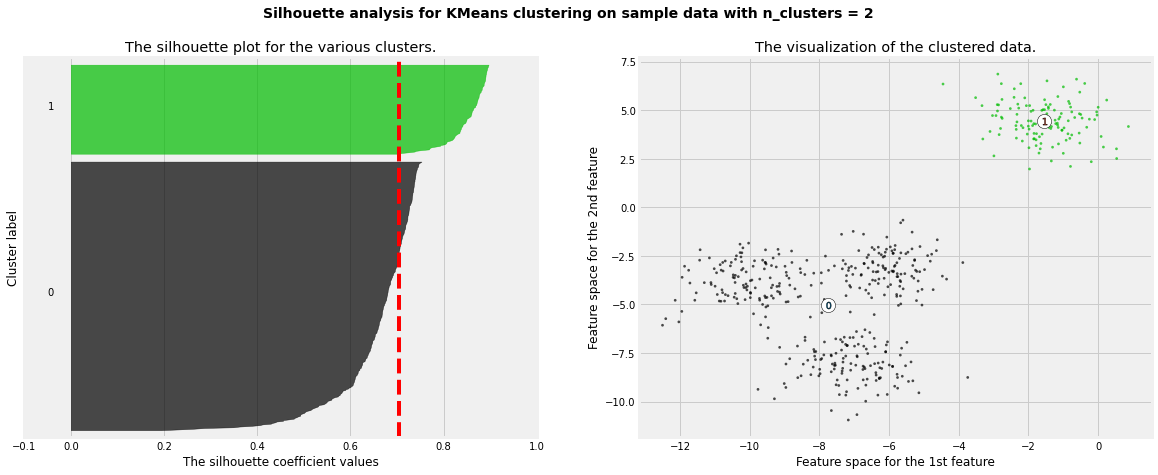

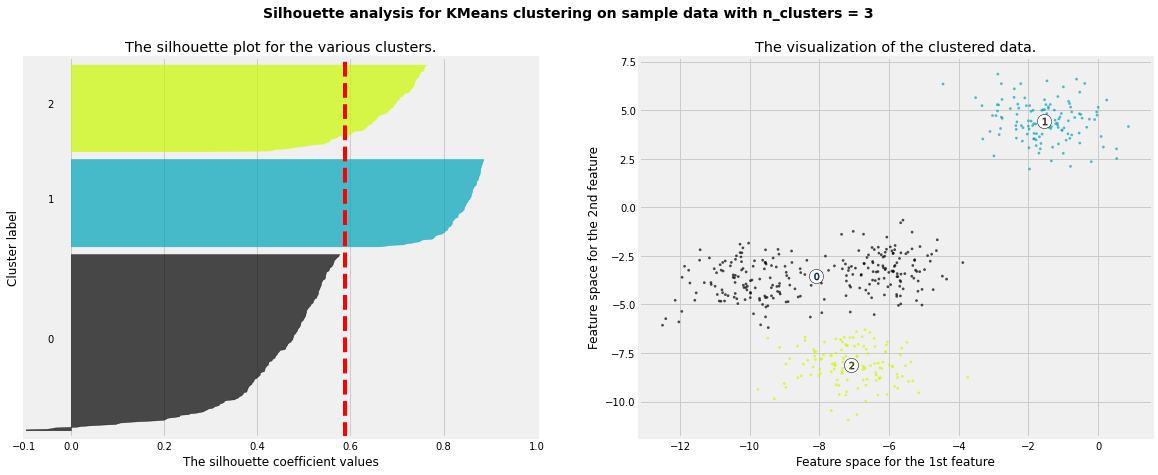

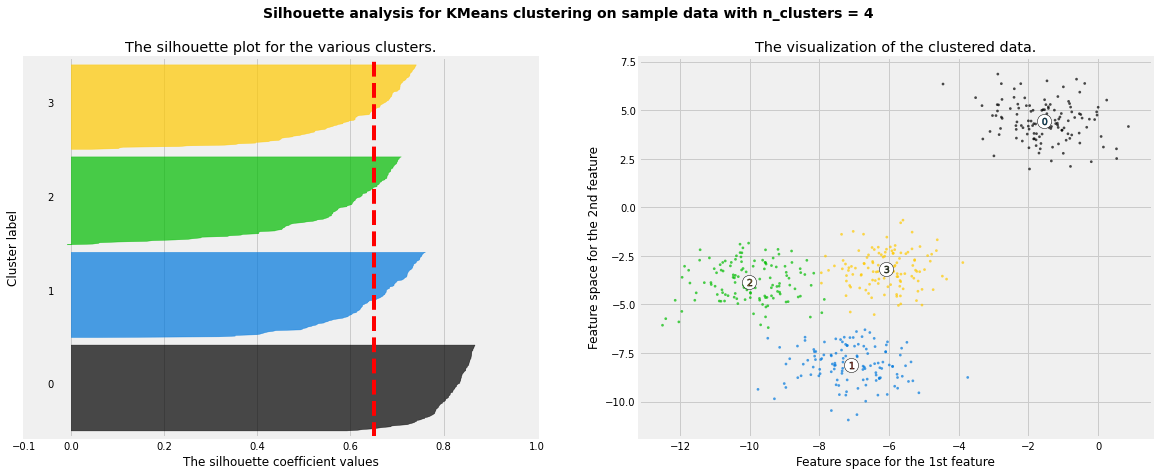

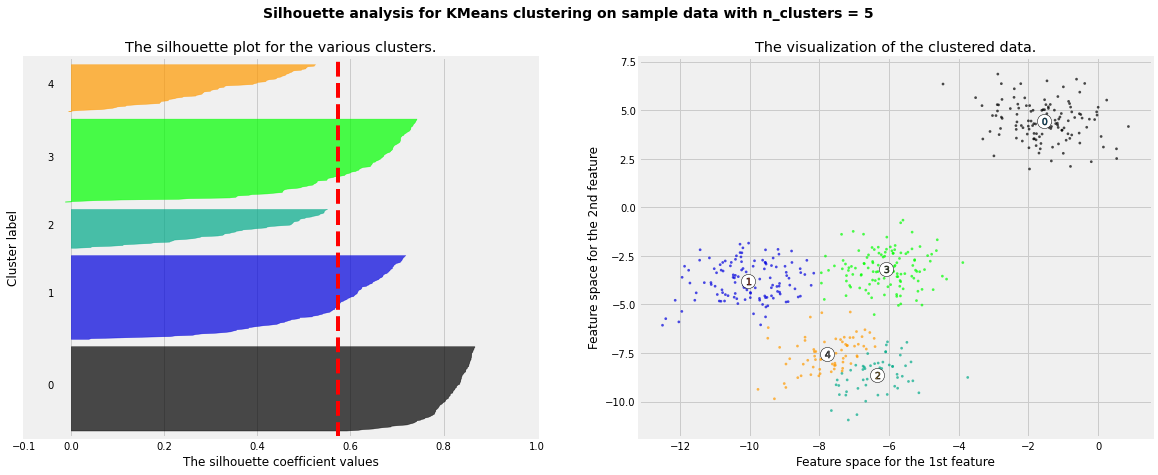

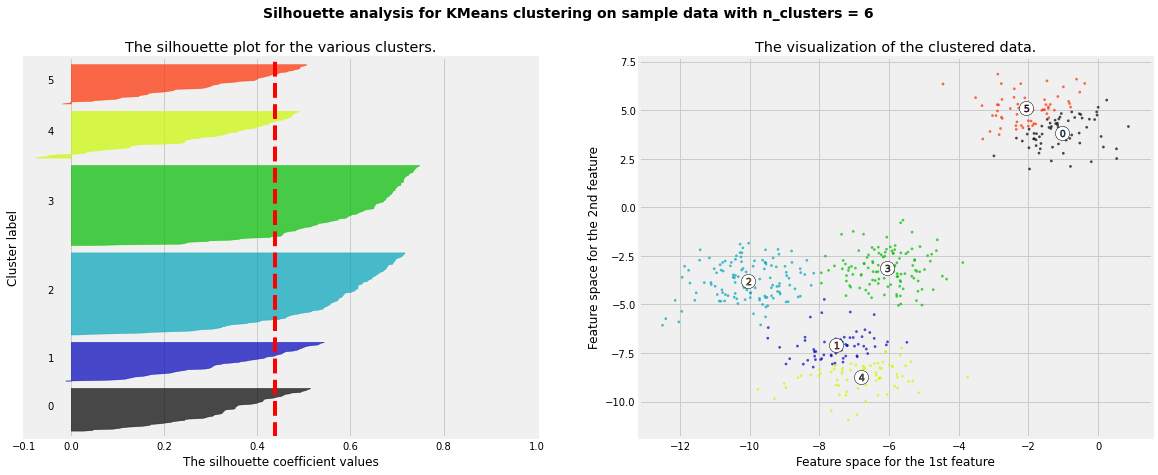

In [45]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
# 시각화 예제
print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

k-means로 Season 변수를 나누었을때 실루엣계수가 0.461으로 막 크게 좋지는 않다.
클러스터 갯수를 나누어 시각화를 했을때 4개의 그룹으로 나누었을때가 가장 각 클러스터간 실루엣 계수가 동일하여 이상적이었다.

4개의 클러스터로 나누어 분류된 그룹의 특성을 알아보면 새로운 정보를 알아낼수도 있을 것이다.

본 교재에서는 이후 내용을 다루지 않으며 본 데이터는 분석 목적이 아닌 머신러닝 실습을 위한 자료이므로 새로운 특징을 알아보는 것은 무의미하다. 이후 작업은 공모전이나 인상깊은 데이터가 생기게 되면 그 때 진행해보고자 하며. 본 노트북을 마치도록 한다.